In [1]:
import numpy as np
from keras import backend as K
from keras.layers import Input, MaxPool2D, Conv2D, UpSampling2D, \
    Concatenate, Maximum, Add, Activation, Lambda
from keras.models import Model
from keras.activations import softmax
import math
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from utils import *

Using TensorFlow backend.


(1024, 1224, 3)


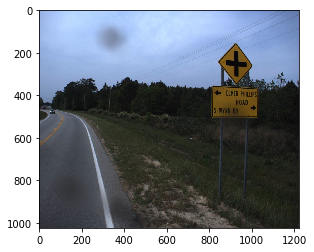

In [2]:
im = cv2.imread("test.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(im.shape)
plt.imshow(im)

In [3]:
angle_count = 8
edge_kernel_size = 7
line_detection_filter_size = 5
square_detection_square_size_count = 1
square_detection_min_square_size = 5
square_detection_max_square_size = 5
square_detection_kernel_size = 11
detection_filter_filter_size = 5
detection_filter_dmz_size = 1
detection_filter_penality = -1
score_filter_size = 5
size_filter_size = 5
pyramid_depth = 7

height, width, _ = im.shape
size = [height, width]
k = math.pow(2, pyramid_depth)
for i, v in enumerate(size):
    v -= (v - edge_kernel_size + 1) % k
    size[i] = int(v)
height, width = size

input_layer = Input(shape=(height,width,3))
edge_layer, edge_weights, edge_bias = get_edge_layer_and_weights(input_filters=3,
                                                                 kernel_size=edge_kernel_size,
                                                                 filters_count=angle_count,
                                                                 padding='valid')
line_layer, line_weights, line_bias = get_line_detection_layer_and_weights(filter_count=angle_count, 
                                                                           angle_increment=math.pi*2/angle_count, 
                                                                           filter_size=line_detection_filter_size)
square_layer, square_weights, square_bias = get_square_detection_layer_and_weights(input_filter_count=angle_count, 
                                                                                   filter_count=square_detection_square_size_count, 
                                                                                   min_square_size=square_detection_min_square_size, 
                                                                                   max_square_size=square_detection_max_square_size, 
                                                                                   kernel_size=square_detection_kernel_size)
max_pool_layer = MaxPool2D(pool_size=(2, 2), padding='same')


filter_layer, filter_weights, filter_bias = get_detection_filter_layer_and_weights(filter_count=pyramid_depth, 
                                                                                   dmz_size=detection_filter_dmz_size, 
                                                                                   other_penality=detection_filter_penality, 
                                                                                   filter_size=detection_filter_filter_size)

score_layer, score_weights, score_bias = get_score_layer_and_weights(input_filter=pyramid_depth,
                                                                     filter_size=score_filter_size)

size_layer, size_weights, size_bias = get_size_layer_and_weights(input_filter=pyramid_depth,
                                                                 filter_size=size_filter_size)


In [4]:
edges = edge_layer(input_layer)
line = line_layer(edges)
pool = max_pool_layer(line)
pyramid = [pool,]
for i in range(1, pyramid_depth):
    line = line_layer(pyramid[-1])
    pool = max_pool_layer(line)
    pyramid.append(pool)
    
squares = [square_layer(l) for l in pyramid]

upsamplings = []
for i, s in enumerate(squares):
    n = math.pow(2, i)
    up = UpSampling2D(size=(n, n), interpolation='bilinear')(s)
    upsamplings.append(up)
    
concat = Concatenate(axis=3)(upsamplings)

filtered = filter_layer(concat)

score = score_layer(filtered)

size_score = Lambda(lambda x: softmax(x, axis=3))(filtered)
size = size_layer(size_score)


In [15]:
model = Model(inputs=input_layer, outputs=[score, size])
# model.compile("SGD", loss='mse')

model.layers[1].set_weights((edge_weights, edge_bias))
model.layers[2].set_weights((line_weights, line_bias))
model.layers[4].set_weights((square_weights, square_bias))
model.layers[13].set_weights((filter_weights, filter_bias))
model.layers[15].set_weights((score_weights, score_bias))
model.layers[16].set_weights((size_weights, score_bias))

model.summary()

ValueError: Layer weight shape (5, 5, 7, 1) not compatible with provided weight shape (5, 5, 1, 7)

In [16]:
input_image = cv2.resize(im, (width, height))
input_image = input_image.astype(np.float).reshape((1,) + input_image.shape)
print(input_image.shape)
pred_list = model.predict(input_image)
try:
    pred_list = pred_list.reshape((-1,) + pred_list.shape)
except AttributeError:
    pass
# print(pred.shape)

(1, 902, 1158, 3)


pred 0: (1, 448, 576, 1)
1.0
pred 1: (1, 448, 576, 1)
1.0


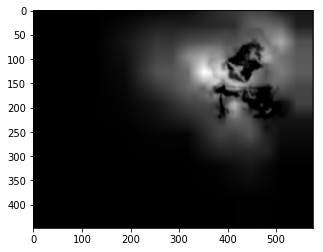

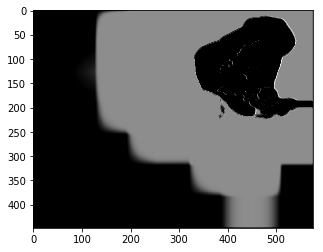

In [17]:
for n, pred in enumerate(pred_list):
    print("pred {}: {}".format(n, pred.shape))
    pred = pred / pred.max()
    for i in range(pred.shape[-1]):
        plt.imshow(pred[0, :, :, i], cmap='gray')
        plt.show()
        print(pred[0, :, :, i].max())

In [18]:
pos = np.unravel_index(np.argmax(pred_list[0][0,:,:,0]), pred_list[0].shape[1:3])
print(pos, pred_list[0].shape)
print(pred_list[0][0, pos[0], pos[1], 0])

(128, 352) (1, 448, 576, 1)
499.358
